# Exercise 6. Part 1. Autoencoders

## Learning goals

The goal of this exercise is to get familiar with autoencoders:
* linear autoencoders
* deep autoencoders with fully-connected layers
* deep convolutional autoencoders

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    # course_data_dir = ...
    # YOUR CODE HERE
    raise NotImplementedError()

print('The data directory is %s' % course_data_dir)

The data directory is /coursedata


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from visualizations import visualize_embeddings, visualize_reconstructions

In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

In [7]:
# We will use FashionMNIST data in this exercise
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))
])

data_dir = os.path.join(course_data_dir, 'fashion_mnist')
print('Data stored in %s' % data_dir)
trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Data stored in /coursedata/fashion_mnist


## Linear autoencoder

We will start with a simple linear autoencoder. Its encoder is defined in the cell below.

In [8]:
class EncoderLinear(nn.Module):
    def __init__(self, n_components):
        super(EncoderLinear, self).__init__()
        self.fc1 = nn.Linear(784, n_components)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)
        x = self.fc1(x)
        return x

Your task is to implement a decoder that "mirrors" the structure of the linear encoder to produce 28x28 images with one channel from a given encoding (a vector with `n_components` elements).

In [9]:
class DecoderLinear(nn.Module):
    # YOUR CODE HERE
    def __init__(self,n_components):
        super(DecoderLinear,self).__init__()
        self.fc1=nn.Linear(n_components,784)
    
    def forward(self,x):
        x=self.fc1(x).view(x.size(0),1,28,28)
        return x
    #raise NotImplementedError()

In [10]:
# Let's test your decoder
n_components = 2
decoder_test = DecoderLinear(n_components)
x = torch.randn(1, 2)
y = decoder_test(x)
assert y.shape == torch.Size([1, 1, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)
print("The shapes seem to be ok.")

The shapes seem to be ok.


In [11]:
# Create a linear autoencoder to encode data into a 10-dimensional vector.
encoder = EncoderLinear(n_components=10)
encoder.to(device)

decoder = DecoderLinear(n_components=10)
decoder.to(device)

DecoderLinear(
  (fc1): Linear(in_features=10, out_features=784, bias=True)
)

In [12]:
# Define a Loss function and optimizer
criterion = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=0.01)

In [13]:
# Train the autoencoder
print_every = 200  # mini-batches
for epoch in range(2):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs = inputs.to(device)

        optimizer.zero_grad()

        encoder_outputs = encoder(inputs)
        decoder_outputs = decoder(encoder_outputs)

        loss = criterion(decoder_outputs, inputs)
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == (print_every-1):    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0

        if skip_training:
            break
    if skip_training:
        break

print('Finished Training')

Finished Training


In [14]:
# Save the model to disk, submit the files together with your notebook
encoder_filename = '6_encoder_linear.pth'
decoder_filename = '6_decoder_linear.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(encoder.state_dict(), encoder_filename)
            torch.save(decoder.state_dict(), decoder_filename)
            print('Model saved to %s, %s.' % (encoder_filename, decoder_filename))
        else:
            print('Model not saved.')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    n_components = 10
    encoder = EncoderLinear(n_components)
    encoder.load_state_dict(torch.load(encoder_filename, map_location=lambda storage, loc: storage))
    print('Encoder loaded from %s.' % encoder_filename)
    encoder.to(device)
    encoder.eval()

    n_components = 10
    decoder = DecoderLinear(n_components)
    decoder.load_state_dict(torch.load(decoder_filename, map_location=lambda storage, loc: storage))
    print('Decoder loaded from %s.' % decoder_filename)
    decoder.to(device)
    decoder.eval()

Encoder loaded from 6_encoder_linear.pth.
Decoder loaded from 6_decoder_linear.pth.


Use t-SNE


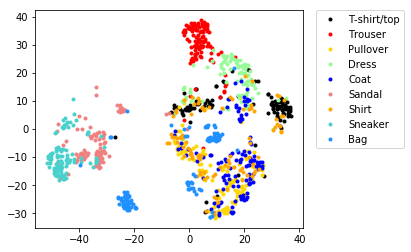

In [15]:
# Let's visualize the latent space
# We visualize 10-dimensional representations with t-SNE projection method.
visualize_embeddings(encoder, testloader, n_samples=1000, device=device)

Note that instances of similar classes end up close to each other in the embedding space.

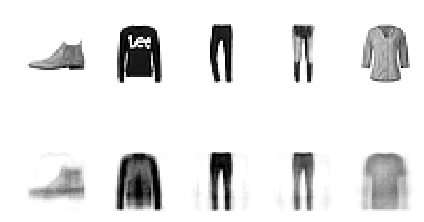

In [16]:
# Let's visualize test images and their reconstructions using the trained autoencoder
visualize_reconstructions(encoder, decoder, testloader, device=device)

## Deep autoencoder

Let us now train a deep autoencoders with fully-connected layers.

The encoder will have three hidden layers with ReLU nonlinearities.

In [17]:
class EncoderDeep(nn.Module):
    def __init__(self, n_components):
        super(EncoderDeep, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, n_components)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Your task is to implement a decoder that "mirrors" the structure of the deep encoder defined above to produce 28x28 images with one channel from a given encoding (a vector with `n_components` elements).

In [18]:
class DecoderDeep(nn.Module):
    # YOUR CODE HERE
    def __init__(self, n_components):
        super(DecoderDeep, self).__init__()
        self.fc1=nn.Linear(n_components,250)
        self.fc2=nn.Linear(250,500)
        self.fc3=nn.Linear(500,1000)
        self.fc4=nn.Linear(1000,784)
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x).view(x.size(0),1,28,28)
        return x
    #raise NotImplementedError()

In [19]:
# Let's test your decoder
n_components = 2
decoder_test = DecoderDeep(n_components)
x = torch.randn(1, n_components)
y = decoder_test(x)
assert y.shape == torch.Size([1, 1, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)
print("The shapes seem to be ok.")

The shapes seem to be ok.


In [20]:
# Create a deep autoencoder
n_components = 10
encoder = EncoderDeep(n_components)
encoder.to(device)

decoder = DecoderDeep(n_components)
decoder.to(device)

DecoderDeep(
  (fc1): Linear(in_features=10, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=784, bias=True)
)

In [21]:
criterion = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=0.001)

In [22]:
# Train the autoencoder
for epoch in range(4):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs = inputs.to(device)

        optimizer.zero_grad()

        encoder_outputs = encoder(inputs)
        decoder_outputs = decoder(encoder_outputs)

        loss = criterion(decoder_outputs, inputs)
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss/200))
            running_loss = 0.0

        if skip_training:
            break
    if skip_training:
        break

print('Finished Training')

Finished Training


In [23]:
# Save the model to disk, submit the files together with your notebook
encoder_filename = '6_encoder_deep.pth'
decoder_filename = '6_decoder_deep.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(encoder.state_dict(), encoder_filename)
            torch.save(decoder.state_dict(), decoder_filename)
            print('Model saved to %s, %s.' % (encoder_filename, decoder_filename))
        else:
            print('Model not saved.')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    n_components = 10
    encoder = EncoderDeep(n_components)
    encoder.load_state_dict(torch.load(encoder_filename, map_location=lambda storage, loc: storage))
    print('Encoder loaded from %s.' % encoder_filename)
    encoder = encoder.to(device)
    encoder.eval()

    n_components = 10
    decoder = DecoderDeep(n_components)
    decoder.load_state_dict(torch.load(decoder_filename, map_location=lambda storage, loc: storage))
    print('Decoder loaded from %s.' % decoder_filename)
    decoder = decoder.to(device)
    decoder.eval()

Encoder loaded from 6_encoder_deep.pth.
Decoder loaded from 6_decoder_deep.pth.


Use t-SNE


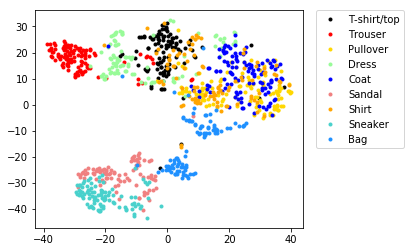

In [24]:
# Let's visualize the latent space
visualize_embeddings(encoder, testloader, n_samples=1000, device=device)

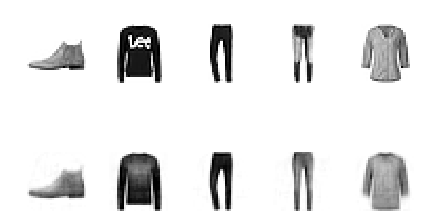

In [25]:
# Let's visualize test images and their reconstructions using the trained autoencoder
visualize_reconstructions(encoder, decoder, testloader, device=device)

## Deep convolutional autoencoder

Let us now train a deep autoencoders with two convolutional layers.

The encoder is defined in the cell below.

In [26]:
class EncoderDeepConv(nn.Module):
    def __init__(self, n_components):
        super(EncoderDeepConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(14*14*16, 250)
        self.fc2 = nn.Linear(250, n_components)

    def forward(self, x, verbose=False):
        if verbose: print('Encoder')
        if verbose: print(x.shape)
        x = F.relu(self.conv1(x))
        if verbose: print(x.shape)
        x = F.relu(self.conv2(x))
        if verbose: print(x.shape)
        x = x.view(-1, self.fc1.in_features)
        if verbose: print(x.shape)
        x = F.relu(self.fc1(x))
        if verbose: print(x.shape)
        x = self.fc2(x)
        if verbose: print(x.shape)
        return x

Your task is to implement a decoder that "mirrors" the structure of the deep encoder defined above to produce 28x28 images with one channel from a given encoding (a vector with `n_components` elements).
* Use [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d) to mirror the convolutional layers.
* Use ReLU after each layer except for the last one.

In [27]:
class DecoderDeepConv(nn.Module):
    # YOUR CODE HERE
    def __init__(self, n_components):
        super(DecoderDeepConv, self).__init__()
        self.fc1=nn.Linear(n_components,250)
        self.fc2=nn.Linear(250,14*14*16)
        self.conv1=nn.ConvTranspose2d(in_channels=16,out_channels=6,kernel_size=5,padding=2)
        self.conv2=nn.ConvTranspose2d(in_channels=6,out_channels=1,kernel_size=5,padding=2,output_padding=1,stride=2)
    def forward(self,x,verbose=False):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.conv1(x.view(x.size(0),self.conv1.in_channels,14,14)))
        x=self.conv2(x)
        return x
    #raise NotImplementedError()

In [28]:
# Let's test your decoder
n_components = 2
encoder_test = EncoderDeepConv(n_components)
y = encoder_test(torch.randn(1, 1, 28, 28), verbose=True)

decoder_test = DecoderDeepConv(n_components)
y = decoder_test(torch.randn(1, n_components), verbose=True)
assert y.shape == torch.Size([1, 1, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)
print("The shapes seem to be ok.")

Encoder
torch.Size([1, 1, 28, 28])
torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 14, 14])
torch.Size([1, 3136])
torch.Size([1, 250])
torch.Size([1, 2])
The shapes seem to be ok.


In [29]:
# Create an autoencoder
n_components = 10
encoder = EncoderDeepConv(n_components)
encoder.to(device)

decoder = DecoderDeepConv(n_components)
decoder.to(device)

DecoderDeepConv(
  (fc1): Linear(in_features=10, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=3136, bias=True)
  (conv1): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): ConvTranspose2d(6, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

In [30]:
criterion = nn.MSELoss()
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=0.001)

In [31]:
# Train the network
for epoch in range(3):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs = inputs.to(device)

        optimizer.zero_grad()

        encoder_outputs = encoder(inputs)
        decoder_outputs = decoder(encoder_outputs)

        loss = criterion(decoder_outputs, inputs)
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss/200))
            running_loss = 0.0

        if skip_training:
            break
    if skip_training:
        break

print('Finished Training')

Finished Training


In [32]:
# Save the model to disk, submit the files together with your notebook
encoder_filename = '6_encoder_deep_conv.pth'
decoder_filename = '6_decoder_deep_conv.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(encoder.state_dict(), encoder_filename)
            torch.save(decoder.state_dict(), decoder_filename)
            print('Model saved to %s, %s.' % (encoder_filename, decoder_filename))
        else:
            print('Model not saved.')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    n_components = 10
    encoder = EncoderDeepConv(n_components)
    encoder.load_state_dict(torch.load(encoder_filename, map_location=lambda storage, loc: storage))
    print('Encoder loaded from %s.' % encoder_filename)
    encoder = encoder.to(device)
    encoder.eval()

    n_components = 10
    decoder = DecoderDeepConv(n_components)
    decoder.load_state_dict(torch.load(decoder_filename, map_location=lambda storage, loc: storage))
    print('Decoder loaded from %s.' % decoder_filename)
    decoder = decoder.to(device)
    decoder.eval()

Encoder loaded from 6_encoder_deep_conv.pth.
Decoder loaded from 6_decoder_deep_conv.pth.


Use t-SNE


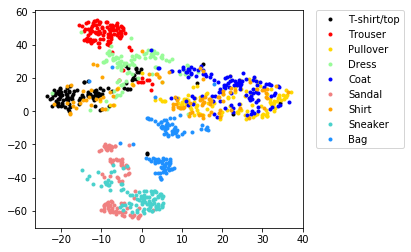

In [33]:
# Let's visualize the latent space
visualize_embeddings(encoder, testloader, n_samples=1000, device=device)

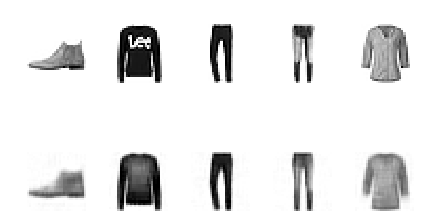

In [34]:
# Let's visualize test images and their reconstructions using the trained autoencoder
visualize_reconstructions(encoder, decoder, testloader, device)